In [1]:
# Import necessary libraries
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import pandas as pd
import seaborn as sns

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.2)


In [2]:
def bolie_model(t, y, f1, f2, f3, f4, J):
    G, I = y
    dGdt = -f1 * G - f2 * I + J
    dIdt = -f3 * I + f4 * G
    return [dGdt, dIdt]


In [ ]:
def extended_model(t, y, f1, f2, f3, f4, J, alpha, beta, SI0, k, K_i=15.0, I_baseline=5.0):
    
    G, I, SI = y
    
    # Convert time from minutes to months for SI calculations
    months_factor = 1/(24*60*30)  # conversion from minutes to months
    
    # Only count insulin above a threshold
    I_excess = max(0, I - I_baseline)
    
    dGdt = -f1 * G - f2 * SI * I * G + J
    dIdt = -f3 * I + (f4 * G) / (1 + k * I)
    
    # Degradation: proportional to excess insulin (consistent across all scenarios)
    # Recovery: proportional to difference from baseline SI (consistent across all scenarios)
    degradation = alpha * I_excess
    recovery = beta * (SI0 - SI)
    
    dSIdt = (-degradation + recovery) * months_factor
    
    return [dGdt, dIdt, dSIdt]

In [ ]:
# Original Bolie model parameters (converted to per-minute)
f1 = 0.0487  # min^-1, glucose removal independent of insulin (δ in Bolie)
f2 = 0.0723  # mL/μU/min, insulin-dependent glucose removal (γ in Bolie)
f3 = 0.013   # min^-1, insulin degradation rate (α in Bolie)
f4 = 0.00347 # μU/mL/mg/dL/min, insulin secretion per glucose (β in Bolie)

# Extended model parameters
k = 0.01     # Pancreatic adaptation parameter
SI0 = 1.0    # Baseline insulin sensitivity

# Saturation and threshold parameters for SI dynamics
K_i = 12.0   # Saturation parameter for insulin effect (μU/mL)
I_baseline = 3.0  # Baseline insulin threshold (μU/mL)

#Insulin resistance development/recovery rates with varying alpha/beta
# These will be used for the first simulation showing different IR development rates
alpha_normal = 0.02    # per month - very minimal degradation per μU/mL excess insulin
beta_normal = 0.02     # per month - recovery toward SI0 (triggers stable mode)

alpha_moderate = 0.012  # per month - very gradual development rate per μU/mL excess insulin
beta_moderate = 0.002    # per month - no recovery

alpha_severe = 0.025    # per month - gentle development rate per μU/mL excess insulin
beta_severe = 0.00002      # per month - no recovery

#Insulin resistance development/recovery rates (per month) - consistent across all diet scenarios
# These rates are applied uniformly to all diet scenarios to isolate the effect of diet on SI
alpha = 0.012    # per month - degradation rate per μU/mL excess insulin
beta = 0.02      # per month - recovery rate toward SI0

In [5]:
def simulate_original_scenarios():
    # Initial conditions
    G0 = 90     # mg/dL, baseline glucose
    I0 = 7      # μU/mL, baseline insulin
    
    # Simulation timeframe: 24 months (2 years)
    t_span = (0, 60*24*30*24)  # 24 months in minutes
    t_eval = np.linspace(0, 60*24*30*24, 20000)  # Evaluation points
    
    # Run simulations for different IR development scenarios
    results = {}
    scenarios = {
        "Normal": (alpha_normal, beta_normal, 1.0),
        "Moderate IR": (alpha_moderate, beta_moderate, 0.85),
        "Severe IR": (alpha_severe, beta_severe, 0.70)
    }
    
    for scenario, (alpha_val, beta_val, SI0_init) in scenarios.items():
        sol = solve_ivp(
            lambda t, y: extended_model(t, y, f1, f2, f3, f4, glucose_input(t, diet_type='moderate'), 
                                       alpha_val, beta_val, SI0, k, K_i, I_baseline),
            t_span, [G0, I0, SI0_init], t_eval=t_eval, method='RK45'
        )
        results[scenario] = sol
    
    # Multiply all glucose values by 10
    for scenario in results:
        results[scenario].y[0] = results[scenario].y[0] * 10
    
    return results, t_eval


In [6]:
def glucose_input(t, diet_type='moderate'):
    # Convert t to hours for easier interpretation
    hour_of_day = (t / 60) % 24
    
    # Define diet profiles with different carbohydrate loads
    diet_profiles = {
        'low-carb': {
            'J_baseline': 1.5,
            'breakfast': 2.0,      # Reduced carb load
            'lunch': 2.5,
            'dinner': 3.0
        },
        'moderate': {
            'J_baseline': 1.5,
            'breakfast': 4.5,      # Standard carb load
            'lunch': 6.0,
            'dinner': 7.0
        },
        'high-carb': {
            'J_baseline': 1.5,
            'breakfast': 7.0,      # High carb load
            'lunch': 9.0,
            'dinner': 10.0
        }
    }
    
    # Get the current diet profile
    profile = diet_profiles.get(diet_type, diet_profiles['moderate'])
    J_baseline = profile['J_baseline']
    
    # Three meals per day
    if 7 <= hour_of_day < 8:  # Breakfast
        return J_baseline + profile['breakfast']
    elif 12 <= hour_of_day < 13:  # Lunch
        return J_baseline + profile['lunch']
    elif 18 <= hour_of_day < 19:  # Dinner
        return J_baseline + profile['dinner']
    return J_baseline

In [7]:
def simulate_long_term_scenarios():
    # Initial conditions - same starting SI for all scenarios
    G0 = 90     # mg/dL, baseline glucose
    I0 = 7      # μU/mL, baseline insulin
    SI0_init = 1.0  # Start with baseline SI for all scenarios
    
    # Simulation timeframe: 24 months (2 years)
    t_span = (0, 60*24*30*120)  # 24 months in minutes
    t_eval = np.linspace(0, 60*24*30*120, 20000)  # Evaluation points (increased for 2 years)
    
    # Run simulations for different diet scenarios with consistent alpha/beta
    results = {}
    diet_scenarios = ['low-carb', 'moderate', 'high-carb']
    
    for diet_type in diet_scenarios:
        sol = solve_ivp(
            lambda t, y: extended_model(t, y, f1, f2, f3, f4, glucose_input(t, diet_type=diet_type), 
                                       alpha, beta, SI0, k, K_i, I_baseline),
            t_span, [G0, I0, SI0_init], t_eval=t_eval, method='RK45'
        )
        results[diet_type] = sol
    
    # Multiply all glucose values by 10
    for diet_type in results:
        results[diet_type].y[0] = results[diet_type].y[0] * 10
    
    return results, t_eval

In [8]:
def plot_long_term_results(results, t_eval):
    
    fig = plt.figure(figsize=(15, 12))
    gs = GridSpec(3, 2, figure=fig)
    
    # Convert time axis from minutes to months for readability
    months = t_eval / (60*24*30)
    
    # Plot insulin sensitivity over time
    ax1 = fig.add_subplot(gs[0, :])
    for diet_type, sol in results.items():
        ax1.plot(months, sol.y[2], label=f'{diet_type.replace("-", " ").title()} Diet', linewidth=2.5)
    
    ax1.set_ylabel('Insulin Sensitivity')
    ax1.set_title('Impact of Diet on Insulin Sensitivity Over 24 Months', fontsize=16)
    ax1.legend(fontsize=12)
    ax1.grid(True)
    ax1.set_ylim(0.45, 1.05)
    ax1.set_xlim(0, 24)  # Extended to 24 months
    
    # Plot monthly average glucose levels
    ax2 = fig.add_subplot(gs[1, 0])
    for diet_type, sol in results.items():
        # Calculate monthly averages
        monthly_glucose = []
        for month in range(24):  # 24 months
            start_idx = np.where(months >= month)[0]
            if len(start_idx) == 0:
                break
            start_idx = start_idx[0]
            end_idx = np.where(months >= month+1)[0]
            if len(end_idx) == 0 or month >= 23:
                end_idx = -1
            else:
                end_idx = end_idx[0]
            monthly_glucose.append(np.mean(sol.y[0][start_idx:end_idx]))
        
        ax2.plot(range(len(monthly_glucose)), monthly_glucose, 'o-', label=f'{diet_type.replace("-", " ").title()} Diet', linewidth=2.5, markersize=4)
    
    ax2.set_ylabel('Monthly Avg Glucose (mg/dL)')
    ax2.set_title('Monthly Average Glucose Levels by Diet', fontsize=14)
    ax2.set_xticks(range(0, 24, 3))
    ax2.set_xticklabels([f'Month {i}' for i in range(0, 24, 3)])
    ax2.grid(True)
    
    # Plot monthly average insulin levels
    ax3 = fig.add_subplot(gs[1, 1])
    for diet_type, sol in results.items():
        # Calculate monthly averages
        monthly_insulin = []
        for month in range(24):  # 24 months
            start_idx = np.where(months >= month)[0]
            if len(start_idx) == 0:
                break
            start_idx = start_idx[0]
            end_idx = np.where(months >= month+1)[0]
            if len(end_idx) == 0 or month >= 23:
                end_idx = -1
            else:
                end_idx = end_idx[0]
            monthly_insulin.append(np.mean(sol.y[1][start_idx:end_idx]))
        
        ax3.plot(range(len(monthly_insulin)), monthly_insulin, 'o-', label=f'{diet_type.replace("-", " ").title()} Diet', linewidth=2.5, markersize=4)
    
    ax3.set_ylabel('Monthly Avg Insulin (μU/mL)')
    ax3.set_title('Monthly Average Insulin Levels by Diet', fontsize=14)
    ax3.set_xticks(range(0, 24, 3))
    ax3.set_xticklabels([f'Month {i}' for i in range(0, 24, 3)])
    ax3.grid(True)
    
    # Plot sample daily glucose profiles at month 1
    ax4 = fig.add_subplot(gs[2, 0])
    for diet_type, sol in results.items():
        # Get a representative day from month 1
        day_start = int(30 * 24 * 60)  # 1 month in minutes
        day_end = day_start + 24 * 60  # 1 day in minutes
        
        # Find closest indices
        start_idx = np.argmin(np.abs(t_eval - day_start))
        end_idx = np.argmin(np.abs(t_eval - day_end))
        
        # Convert to hours for this day
        hours = (t_eval[start_idx:end_idx] - day_start) / 60
        
        ax4.plot(hours, sol.y[0][start_idx:end_idx], label=f'{diet_type.replace("-", " ").title()} Diet', linewidth=2)
    
    ax4.set_xlabel('Hour of Day')
    ax4.set_ylabel('Glucose (mg/dL)')
    ax4.set_title('Daily Glucose Profile - Month 1', fontsize=14)
    ax4.set_xlim(0, 24)
    ax4.legend(fontsize=10)
    ax4.grid(True)
    
    # Plot sample daily glucose profiles at final month (Month 24)
    ax5 = fig.add_subplot(gs[2, 1])
    for diet_type, sol in results.items():
        # Get a representative day from month 24 (final month)
        day_start = int(23.5 * 30 * 24 * 60)  # 23.5 months in minutes (middle of final month)
        day_end = day_start + 24 * 60  # 1 day in minutes
        
        # Find closest indices
        start_idx = np.argmin(np.abs(t_eval - day_start))
        end_idx = np.argmin(np.abs(t_eval - day_end))
        
        # Convert to hours for this day
        hours = (t_eval[start_idx:end_idx] - day_start) / 60
        
        ax5.plot(hours, sol.y[0][start_idx:end_idx], label=f'{diet_type.replace("-", " ").title()} Diet', linewidth=2)
    
    ax5.set_xlabel('Hour of Day')
    ax5.set_ylabel('Glucose (mg/dL)')
    ax5.set_title('Daily Glucose Profile - Month 24 (Final)', fontsize=14)
    ax5.set_xlim(0, 24)
    ax5.legend(fontsize=10)
    ax5.grid(True)
    
    plt.tight_layout()
    plt.savefig('long_term_insulin_resistance_model.png', dpi=300)
    plt.show()

In [9]:
def plot_original_results(results, t_eval):
    """
    Plot the original scenario results (Normal, Moderate IR, Severe IR) with 5 subplots:
    1. Insulin sensitivity over time
    2. Monthly average glucose levels
    3. Monthly average insulin levels
    4. Daily glucose profile at Month 1
    5. Daily glucose profile at Month 24
    """
    fig = plt.figure(figsize=(15, 12))
    gs = GridSpec(3, 2, figure=fig)
    
    # Convert time axis from minutes to months for readability
    months = t_eval / (60*24*30)
    
    # Plot insulin sensitivity over time
    ax1 = fig.add_subplot(gs[0, :])
    for scenario, sol in results.items():
        ax1.plot(months, sol.y[2], label=scenario, linewidth=2.5)
    
    ax1.set_ylabel('Insulin Sensitivity')
    ax1.set_title('(a) Insulin Resistance Development/Recovery Rates (Moderate Diet)', fontsize=16)
    ax1.legend(fontsize=12)
    ax1.grid(True)
    ax1.set_ylim(0.45, 1.05)
    ax1.set_xlim(0, 24)
    
    # Plot monthly average glucose levels
    ax2 = fig.add_subplot(gs[1, 0])
    for scenario, sol in results.items():
        monthly_glucose = []
        for month in range(24):
            start_idx = np.where(months >= month)[0]
            if len(start_idx) == 0:
                break
            start_idx = start_idx[0]
            end_idx = np.where(months >= month+1)[0]
            if len(end_idx) == 0 or month >= 23:
                end_idx = -1
            else:
                end_idx = end_idx[0]
            monthly_glucose.append(np.mean(sol.y[0][start_idx:end_idx]))
        
        ax2.plot(range(len(monthly_glucose)), monthly_glucose, 'o-', label=scenario, linewidth=2.5, markersize=4)
    
    ax2.set_ylabel('Monthly Avg Glucose (mg/dL)')
    ax2.set_title('(b) Monthly Average Glucose Levels', fontsize=14)
    ax2.set_xticks(range(0, 24, 3))
    ax2.set_xticklabels([f'Month {i}' for i in range(0, 24, 3)])
    ax2.grid(True)
    
    # Plot monthly average insulin levels
    ax3 = fig.add_subplot(gs[1, 1])
    for scenario, sol in results.items():
        monthly_insulin = []
        for month in range(24):
            start_idx = np.where(months >= month)[0]
            if len(start_idx) == 0:
                break
            start_idx = start_idx[0]
            end_idx = np.where(months >= month+1)[0]
            if len(end_idx) == 0 or month >= 23:
                end_idx = -1
            else:
                end_idx = end_idx[0]
            monthly_insulin.append(np.mean(sol.y[1][start_idx:end_idx]))
        
        ax3.plot(range(len(monthly_insulin)), monthly_insulin, 'o-', label=scenario, linewidth=2.5, markersize=4)
    
    ax3.set_ylabel('Monthly Avg Insulin (μU/mL)')
    ax3.set_title('(c) Monthly Average Insulin Levels', fontsize=14)
    ax3.set_xticks(range(0, 24, 3))
    ax3.set_xticklabels([f'Month {i}' for i in range(0, 24, 3)])
    ax3.grid(True)
    
    # Plot sample daily glucose profiles at month 1
    ax4 = fig.add_subplot(gs[2, 0])
    for scenario, sol in results.items():
        day_start = int(30 * 24 * 60)
        day_end = day_start + 24 * 60
        start_idx = np.argmin(np.abs(t_eval - day_start))
        end_idx = np.argmin(np.abs(t_eval - day_end))
        hours = (t_eval[start_idx:end_idx] - day_start) / 60
        ax4.plot(hours, sol.y[0][start_idx:end_idx], label=scenario, linewidth=2)
    
    ax4.set_xlabel('Hour of Day')
    ax4.set_ylabel('Glucose (mg/dL)')
    ax4.set_title('(d) Daily Glucose Profile - Month 1', fontsize=14)
    ax4.set_xlim(0, 24)
    ax4.legend(fontsize=10)
    ax4.grid(True)
    
    # Plot sample daily glucose profiles at final month (Month 24)
    ax5 = fig.add_subplot(gs[2, 1])
    for scenario, sol in results.items():
        day_start = int(23.5 * 30 * 24 * 60)
        day_end = day_start + 24 * 60
        start_idx = np.argmin(np.abs(t_eval - day_start))
        end_idx = np.argmin(np.abs(t_eval - day_end))
        hours = (t_eval[start_idx:end_idx] - day_start) / 60
        ax5.plot(hours, sol.y[0][start_idx:end_idx], label=scenario, linewidth=2)
    
    ax5.set_xlabel('Hour of Day')
    ax5.set_ylabel('Glucose (mg/dL)')
    ax5.set_title('(e) Daily Glucose Profile - Month 24 (Final)', fontsize=14)
    ax5.set_xlim(0, 24)
    ax5.legend(fontsize=10)
    ax5.grid(True)
    
    plt.tight_layout()
    plt.savefig('original_ir_scenarios.png', dpi=300)
    plt.show()


In [10]:
def standardized_meal_input(t, meal_duration_minutes=60, baseline_input=1.5, meal_magnitude=6.0):
    # Meal starts at t=30 minutes (30 min after baseline period)
    meal_start = 30
    meal_end = meal_start + meal_duration_minutes
    
    if meal_start <= t < meal_end:
        return baseline_input + meal_magnitude
    else:
        return baseline_input

def simulate_meal_snapshots(results, t_eval, diet_types=['low-carb', 'moderate', 'high-carb']):
    meal_snapshots = {}
    
    # For each diet, get the SI value at month 1 and month 24 from the long-term results
    months = t_eval / (60*24*30)
    
    for diet_type in diet_types:
        if diet_type not in results:
            continue
            
        # Get SI at month 1
        month1_idx = np.argmin(np.abs(months - 1.0))
        SI_month1 = results[diet_type].y[2][month1_idx]
        
        # Get SI at month 24
        month24_idx = np.argmin(np.abs(months - 24.0))
        SI_month24 = results[diet_type].y[2][month24_idx]
        
        # Simulate meal response at month 1
        # Total duration: 30 min baseline + 60 min meal + 90 min recovery = 180 min (3 hours)
        t_start_1 = 0
        t_end_1 = 180  # 3 hours total
        
        sol_month1 = solve_ivp(
            lambda t, y: extended_model(t, y, f1, f2, f3, f4, standardized_meal_input(t),
                                       alpha, beta, SI0, k, K_i, I_baseline),
            (t_start_1, t_end_1), [9, 7, SI_month1], t_eval=np.linspace(t_start_1, t_end_1, 500), method='RK45'
        )
        
        # Simulate meal response at month 24 (same meal, different SI)
        t_start_24 = 0
        t_end_24 = 180  # 3 hours total
        
        sol_month24 = solve_ivp(
            lambda t, y: extended_model(t, y, f1, f2, f3, f4, standardized_meal_input(t),
                                       alpha, beta, SI0, k, K_i, I_baseline),
            (t_start_24, t_end_24), [9, 7, SI_month24], t_eval=np.linspace(t_start_24, t_end_24, 500), method='RK45'
        )
        
        meal_snapshots[diet_type] = {
            'month1': (sol_month1, SI_month1),
            'month24': (sol_month24, SI_month24)
        }
        #multiply glucose values by 10
        meal_snapshots[diet_type]['month1'][0].y[0] = meal_snapshots[diet_type]['month1'][0].y[0] * 10
        meal_snapshots[diet_type]['month24'][0].y[0] = meal_snapshots[diet_type]['month24'][0].y[0] * 10
        
    return meal_snapshots

def plot_diet_comparison(results, t_eval, meal_snapshots):
    """
    Create comparison plot showing:
    - Top: SI trajectories over 24 months for all diets
    - Bottom left: Single standardized meal response at month 1
    - Bottom right: Single standardized meal response at month 24
    """
    fig = plt.figure(figsize=(15, 10))
    gs = GridSpec(2, 2, figure=fig, height_ratios=[1, 1])
    
    # Convert time axis from minutes to months for readability
    months = t_eval / (60*24*30)
    
    # Plot 1: Insulin sensitivity over 24 months (spans both columns)
    ax1 = fig.add_subplot(gs[0, :])
    diet_colors = {'low-carb': 'blue', 'moderate': 'orange', 'high-carb': 'green'}
    
    for diet_type, sol in results.items():
        color = diet_colors.get(diet_type, 'gray')
        ax1.plot(months, sol.y[2], label=f'{diet_type.replace("-", " ").title()} Diet', 
                linewidth=2.5, color=color)
    
    ax1.set_ylabel('Insulin Sensitivity', fontsize=12)
    ax1.set_title('Impact of Diet on Insulin Sensitivity Over 24 Months', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=11, loc='best')
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(0.45, 1.05)
    ax1.set_xlim(0, 24)
    
    # Plot 2: Standardized meal response at Month 1 (bottom left)
    ax2 = fig.add_subplot(gs[1, 0])
    for diet_type, snapshot in meal_snapshots.items():
        sol_month1, SI_month1 = snapshot['month1']
        # Time is already in minutes from meal period start
        time_minutes = sol_month1.t
        ax2.plot(time_minutes, sol_month1.y[0], label=f'{diet_type.replace("-", " ").title()} (SI={SI_month1:.3f})', 
                linewidth=2.5, color=diet_colors.get(diet_type, 'gray'))
    
    # Shade the meal period (30-90 minutes)
    ax2.axvspan(30, 90, alpha=0.1, color='yellow', label='Meal period')
    ax2.axvline(x=30, color='red', linestyle='--', alpha=0.5, linewidth=1.5)
    ax2.set_xlabel('Time (minutes)', fontsize=11)
    ax2.set_ylabel('Glucose (mg/dL)', fontsize=11)
    ax2.set_title('Meal Response - Month 1 (Early Intervention)', fontsize=12, fontweight='bold')
    ax2.legend(fontsize=9, loc='upper right')
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Standardized meal response at Month 24 (bottom right)
    ax3 = fig.add_subplot(gs[1, 1])
    for diet_type, snapshot in meal_snapshots.items():
        sol_month24, SI_month24 = snapshot['month24']
        # Time is already in minutes from meal period start
        time_minutes = sol_month24.t
        ax3.plot(time_minutes, sol_month24.y[0], label=f'{diet_type.replace("-", " ").title()} (SI={SI_month24:.3f})', 
                linewidth=2.5, color=diet_colors.get(diet_type, 'gray'))
    
    # Shade the meal period (30-90 minutes)
    ax3.axvspan(30, 90, alpha=0.1, color='yellow', label='Meal period')
    ax3.axvline(x=30, color='red', linestyle='--', alpha=0.5, linewidth=1.5)
    ax3.set_xlabel('Time (minutes)', fontsize=11)
    ax3.set_ylabel('Glucose (mg/dL)', fontsize=11)
    ax3.set_title('Meal Response - Month 24 (After 2 Years)', fontsize=12, fontweight='bold')
    ax3.legend(fontsize=9, loc='upper right')
    ax3.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('diet_impact_with_meals.png', dpi=300)
    plt.show()


In [ ]:
def standardized_meal_input(t, meal_duration_minutes=60, baseline_input=1.5, meal_magnitude=6.0):
    # Meal starts at t=30 minutes (30 min after baseline period)
    meal_start = 30
    meal_end = meal_start + meal_duration_minutes
    
    if meal_start <= t < meal_end:
        return baseline_input + meal_magnitude
    else:
        return baseline_input

def simulate_meal_snapshots(results, t_eval, diet_types=['low-carb', 'moderate', 'high-carb']):
    """
    Simulate single meal response at Month 1 and Month 120 for diet comparison.
    All three diets receive the same standardized meal to isolate insulin sensitivity effects.
    
    """
    meal_snapshots = {}
    
    # For each diet, get the SI value at month 1 and month 120 from the long-term results
    months = t_eval / (60*24*30)
    
    for diet_type in diet_types:
        if diet_type not in results:
            continue
            
        # Get SI at month 1
        month1_idx = np.argmin(np.abs(months - 1.0))
        SI_month1 = results[diet_type].y[2][month1_idx]
        
        # Get SI at month 120 (Year 10, final)
        month120_idx = np.argmin(np.abs(months - 120.0))
        SI_month120 = results[diet_type].y[2][month120_idx]
        
        # Simulate meal response at month 1
        # Total duration: 30 min baseline + 60 min meal + 90 min recovery = 180 min (3 hours)
        t_start_1 = 0
        t_end_1 = 180  # 3 hours total
        
        sol_month1 = solve_ivp(
            lambda t, y: extended_model(t, y, f1, f2, f3, f4, standardized_meal_input(t),
                                       alpha, beta, SI0, k, K_i, I_baseline),
            (t_start_1, t_end_1), [9, 7, SI_month1], t_eval=np.linspace(t_start_1, t_end_1, 500), method='RK45'
        )
        
        # Simulate meal response at month 120 (Year 10, final - same meal, different SI)
        t_start_120 = 0
        t_end_120 = 180  # 3 hours total
        
        sol_month120 = solve_ivp(
            lambda t, y: extended_model(t, y, f1, f2, f3, f4, standardized_meal_input(t),
                                       alpha, beta, SI0, k, K_i, I_baseline),
            (t_start_120, t_end_120), [9, 7, SI_month120], t_eval=np.linspace(t_start_120, t_end_120, 500), method='RK45'
        )
        
        meal_snapshots[diet_type] = {
            'month1': (sol_month1, SI_month1),
            'month120': (sol_month120, SI_month120)
        }
        #multiply glucose values by 10 for realism
        meal_snapshots[diet_type]['month1'][0].y[0] = meal_snapshots[diet_type]['month1'][0].y[0] * 10
        meal_snapshots[diet_type]['month120'][0].y[0] = meal_snapshots[diet_type]['month120'][0].y[0] * 10
        
    return meal_snapshots


In [12]:
def plot_diet_comparison(results, t_eval, meal_snapshots):
    """
    Create comparison plot showing:
    - Top: SI trajectories over 120 months for all diets
    - Bottom left: Single standardized meal response at month 1
    - Bottom right: Single standardized meal response at month 120 (Year 10)
    """
    fig = plt.figure(figsize=(15, 10))
    gs = GridSpec(2, 2, figure=fig, height_ratios=[1, 1])
    
    # Convert time axis from minutes to months for readability
    months = t_eval / (60*24*30)
    
    # Plot 1: Insulin sensitivity over 120 months (spans both columns)
    ax1 = fig.add_subplot(gs[0, :])
    diet_colors = {'low-carb': 'blue', 'moderate': 'orange', 'high-carb': 'green'}
    
    for diet_type, sol in results.items():
        color = diet_colors.get(diet_type, 'gray')
        ax1.plot(months, sol.y[2], label=f'{diet_type.replace("-", " ").title()} Diet', 
                linewidth=2.5, color=color)
    
    ax1.set_ylabel('Insulin Sensitivity', fontsize=12)
    ax1.set_title('(a) Impact of Diet on Insulin Sensitivity Over 120 Months (10 Years)', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=11, loc='best')
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(0.45, 1.05)
    ax1.set_xlim(0, 120)
    
    # Plot 2: Standardized meal response at Month 1 (bottom left)
    ax2 = fig.add_subplot(gs[1, 0])
    for diet_type, snapshot in meal_snapshots.items():
        sol_month1, SI_month1 = snapshot['month1']
        # Time is already in minutes from meal period start
        time_minutes = sol_month1.t
        ax2.plot(time_minutes, sol_month1.y[0], label=f'{diet_type.replace("-", " ").title()} (SI={SI_month1:.3f})', 
                linewidth=2.5, color=diet_colors.get(diet_type, 'gray'))
    
    # Shade the meal period (30-90 minutes)
    ax2.axvspan(30, 90, alpha=0.1, color='yellow', label='Meal period')
    ax2.axvline(x=30, color='red', linestyle='--', alpha=0.5, linewidth=1.5)
    ax2.set_xlabel('Time (minutes)', fontsize=11)
    ax2.set_ylabel('Glucose (mg/dL)', fontsize=11)
    ax2.set_title('(b) Meal Response - Month 1 (Early Intervention)', fontsize=12, fontweight='bold')
    ax2.legend(fontsize=9, loc='upper right')
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Standardized meal response at Month 120 (bottom right)
    ax3 = fig.add_subplot(gs[1, 1])
    for diet_type, snapshot in meal_snapshots.items():
        sol_month120, SI_month120 = snapshot['month120']
        # Time is already in minutes from meal period start
        time_minutes = sol_month120.t
        ax3.plot(time_minutes, sol_month120.y[0], label=f'{diet_type.replace("-", " ").title()} (SI={SI_month120:.3f})', 
                linewidth=2.5, color=diet_colors.get(diet_type, 'gray'))
    
    # Shade the meal period (30-90 minutes)
    ax3.axvspan(30, 90, alpha=0.1, color='yellow', label='Meal period')
    ax3.axvline(x=30, color='red', linestyle='--', alpha=0.5, linewidth=1.5)
    ax3.set_xlabel('Time (minutes)', fontsize=11)
    ax3.set_ylabel('Glucose (mg/dL)', fontsize=11)
    ax3.set_title('(c) Meal Response - Month 120 (Year 10, Final)', fontsize=12, fontweight='bold')
    ax3.legend(fontsize=9, loc='upper right')
    ax3.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('diet_impact_with_meals.png', dpi=300)
    plt.show()



Running original IR development scenarios simulation...


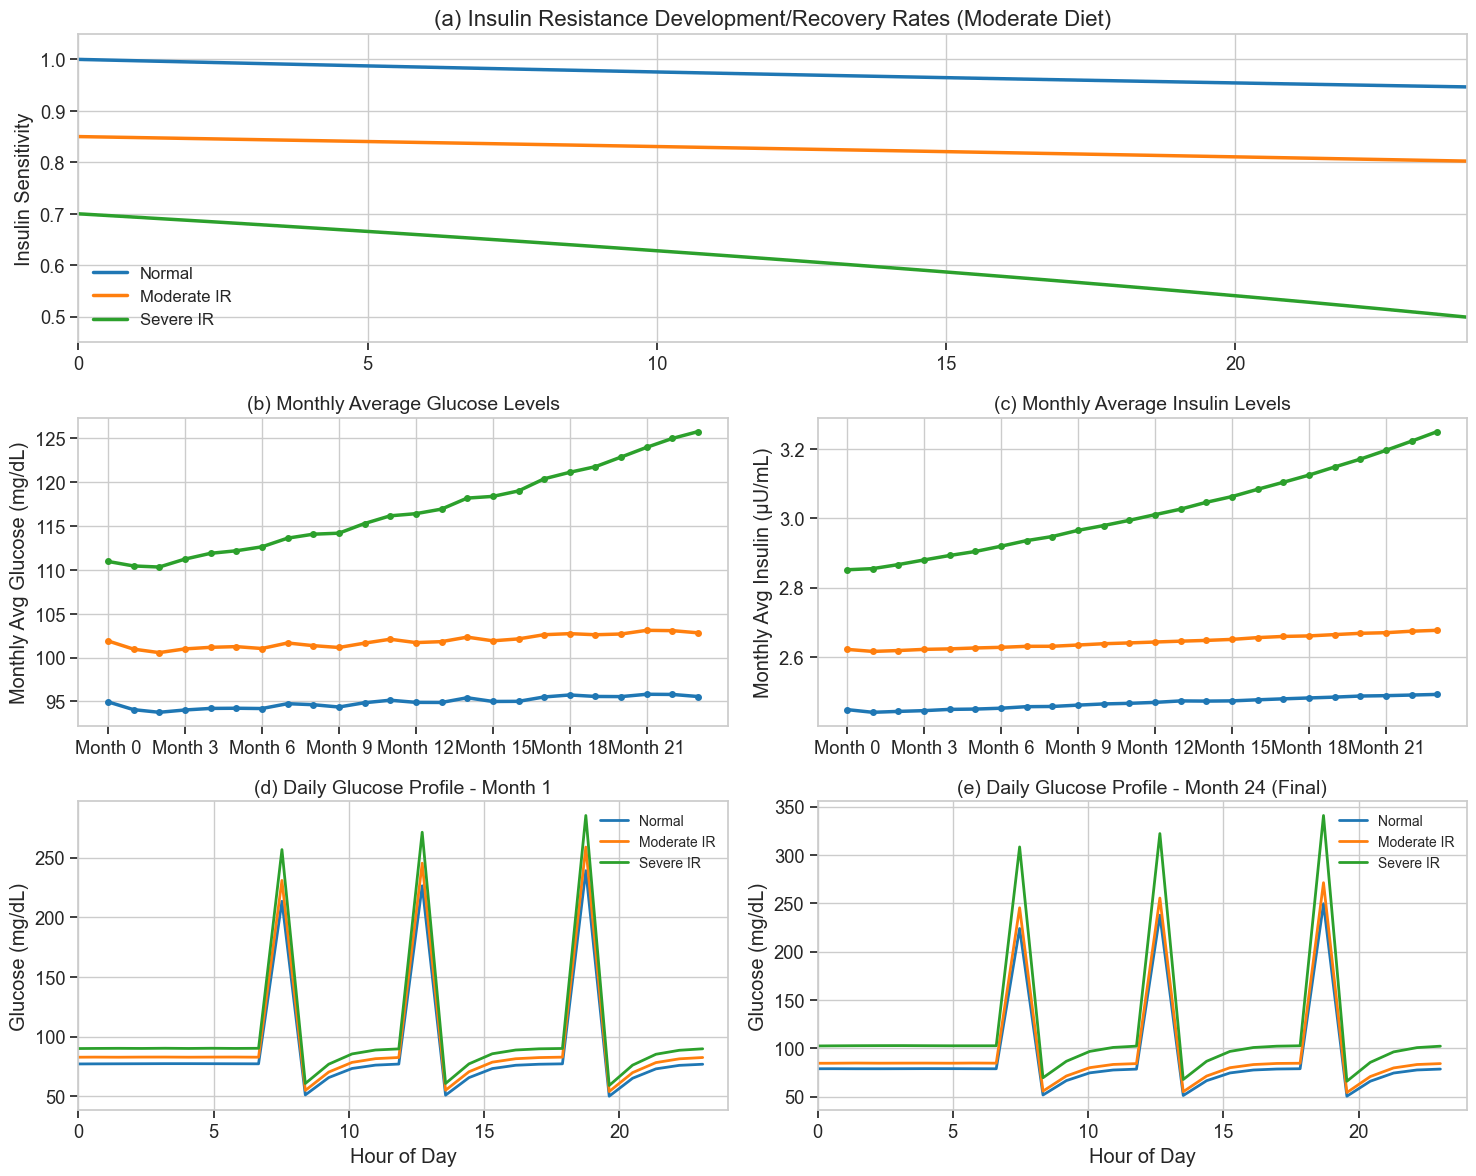


Running diet impact simulation...
Generating meal snapshots for dietary comparison...

Chart 2: Diet comparison with meal responses...


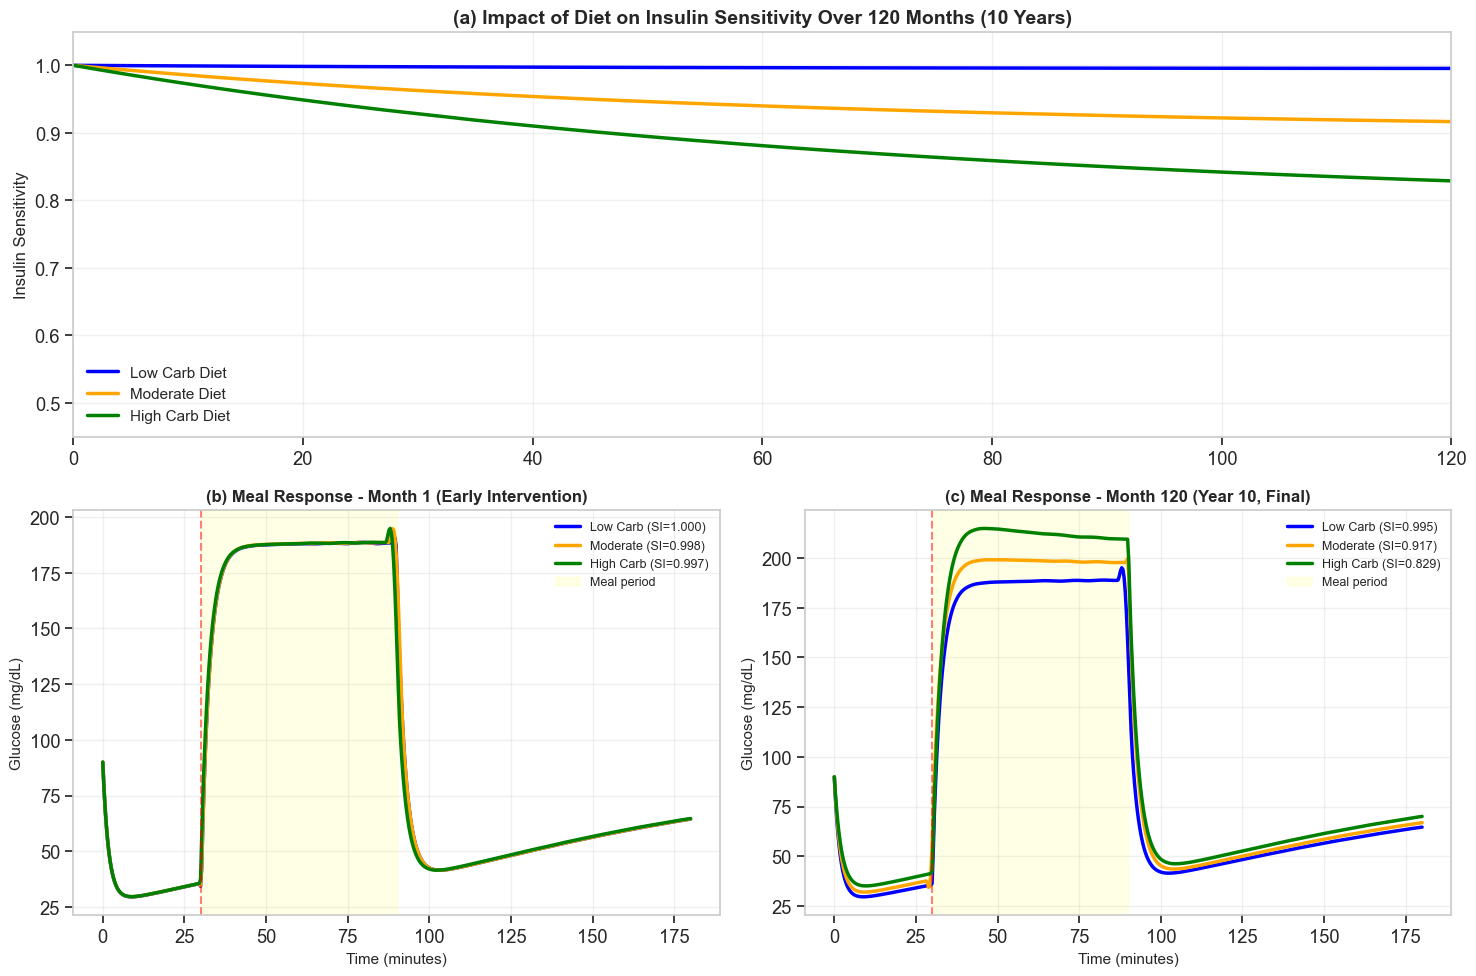

In [ ]:
# Chart 1: Original IR Development Scenarios =====
print("Running original IR development scenarios simulation...")
original_results, original_t_eval = simulate_original_scenarios()
plot_original_results(original_results, original_t_eval)

# Chart 2: Long-Term Diet Impact Scenarios =====
print("\nRunning diet impact simulation...")
results, t_eval = simulate_long_term_scenarios()

print("Generating meal snapshots for dietary comparison...")
meal_snapshots = simulate_meal_snapshots(results, t_eval)

print("\nChart 2: Diet comparison with meal responses...")
plot_diet_comparison(results, t_eval, meal_snapshots)
